# Chapter 2: Deterministic models
This chapter aims to show two regression models defined in Pytorch from scratches.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

## S2-1: A standard regression model
This is an elementary implementation of a regression model in Pytorch.

First, we define the device (GPU/CPU) we are working with:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


The data frame is the linear relationship without noise introduced in step_1, we explicitly split the data frame into training/validation/test set.

In [3]:
full_df = pd.read_csv(os.path.join(path_data, "df_linear.csv"))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

full_df.head(8)

,x_range,y_range,split_label
0,-100.000000,-193.000000,0
1,-98.994975,-190.989950,2
2,-97.989950,-188.979899,0
3,-96.984925,-186.969849,0
4,-95.979899,-184.959799,0
5,-94.974874,-182.949749,0
6,-93.969849,-180.939698,0
7,-92.964824,-178.929648,1


We define a CustomDataset from Pytorch Dataset. The dataset has an *init* (initialise the class), a *len* and a *getitem* method.
A Dataset must provide the tools to identify available data and return all the elements needed to train/test/evaluate the model.

Can be skipped if the data is particularly simple.

In [4]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])
        
        return torch.tensor(x_range).view(1), torch.tensor(y_range).view(1)

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file='df_linear.csv', path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example (x_range,y_range)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file='df_linear.csv', path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file='df_linear.csv', path_data=path_data, split_label=2)

Length training dataset: 160
Output example (x_range,y_range)=((tensor([-63.8191]), tensor([-120.6382]))) with index 27.


To define a batch we can iterate on the whole dataset or define a *DataLoader* which samples from the introduced DataSet and can be iterated during training. It provides a batch of tensors to apply the computations efficiently at the same time.

In [5]:
# Size of each batch
batch_size = 10  

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# An example of iteration on the DataLoader:
x_example, y_example = next(iter(training_dataloader))
print(f"(x_example,y_example)=({x_example},{y_example})")
print(f"Data loaded shape: {x_example.shape}")

(x_example,y_example)=(tensor([[ 18.5930],
        [-57.7889],
        [ 38.6935],
        [ 69.8492],
        [ 26.6332],
        [ 20.6030],
        [-12.5628],
        [ -6.5327],
        [ 28.6432],
        [ 22.6131]]),tensor([[  44.1859],
        [-108.5779],
        [  84.3869],
        [ 146.6985],
        [  60.2663],
        [  48.2060],
        [ -18.1256],
        [  -6.0653],
        [  64.2864],
        [  52.2261]]))
Data loaded shape: torch.Size([10, 1])


Introduce a (small) model to approximate the relationship:

In [6]:
# Define the model:
model = nn.Sequential(
    nn.Linear(1, 4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4, 1)
)

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

To define a more complex model (instead of a sequential one), we can explicitely define it from the torch.nn.Module as follows:

In [7]:
class CustomRegressionANN(nn.Module):
    def __init__(self):
        super(CustomRegressionANN, self).__init__()
        
        # Define the layers to be used in the forward pass:
        self.fc1 = nn.Linear(1, 4)  # First Linear layer (input size: 1, output size: 4)
        self.fc2 = nn.Linear(4, 4)  # Second Linear layer (input size: 4, output size: 4)
        self.fc3 = nn.Linear(4, 1)  # Third Linear layer (input size: 4, output size: 1)
        
        self.relu = nn.ReLU()       # ReLU activation function

    def forward(self, x):
        # Define the forward pass explicitly (by telling the network how to combine the previous layers)
        x = self.fc1(x)             # Pass through the first layer
        x = self.relu(x)            # Apply ReLU activation
        
        x = self.fc2(x)             # Pass through the second layer
        x = self.relu(x)            # Apply ReLU activation
        
        x = self.fc3(x)             # Pass through the final layer
        
        return x

# Make an instance of the custom ANN defined
model = CustomRegressionANN()

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

Introduce the loss and the optimiser. Both can be implemented explicitly. The loss can be any function relating predictions and ground truths.

In [8]:
# Loss function (Mean Squared Error):
loss_fn = nn.MSELoss()  

# Optimizer (Adam): 
learning_rate = 1e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle: 
- The model is trained for a given number of epochs *n_epochs*
- Each epoch iterates over the entire dataset (*shuffle == True* just randomly shuffles indices) using the dataloader to generate batches.
- For each batch, the gradients are computed on the whole batch to the respect of the loss function and the optimizer it is used to update model trainable parameters


In [9]:
# Number of training epochs:
n_epochs = 100

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  

        # Compute loss (supervised case)
        loss = loss_fn(y_model, y_output)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

        
            # Forward pass (model calls)
            y_model = model(x_input)

            # Compute loss (supervised case)
            loss = loss_fn(y_model, y_output)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            

    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/100], Loss: 13106.7856, Val. Loss: 14010.8490
Epoch [2/100], Loss: 12906.8420, Val. Loss: 14003.3202
Epoch [3/100], Loss: 12897.1463, Val. Loss: 13993.0690
Epoch [4/100], Loss: 12884.0319, Val. Loss: 13977.6179
Epoch [5/100], Loss: 12863.8251, Val. Loss: 13956.0911
Epoch [6/100], Loss: 12836.1699, Val. Loss: 13925.0152
Epoch [7/100], Loss: 12795.7116, Val. Loss: 13882.1240
Epoch [8/100], Loss: 12739.9829, Val. Loss: 13826.3079
Epoch [9/100], Loss: 12670.2640, Val. Loss: 13751.3320
Epoch [10/100], Loss: 12576.3395, Val. Loss: 13661.4162
Epoch [11/100], Loss: 12469.9517, Val. Loss: 13548.3172
Epoch [12/100], Loss: 12334.1785, Val. Loss: 13423.9889
Epoch [13/100], Loss: 12184.1977, Val. Loss: 13280.3305
Epoch [14/100], Loss: 12010.1232, Val. Loss: 13127.0767
Epoch [15/100], Loss: 11837.2452, Val. Loss: 12946.2709
Epoch [16/100], Loss: 11627.5229, Val. Loss: 12767.6797
Epoch [17/100], Loss: 11421.7161, Val. Loss: 12575.6775
Epoch [18/100], Loss: 11205.6218, Val. Loss: 12374.8496
E

Plot the convergence graphs on training and validation sets:

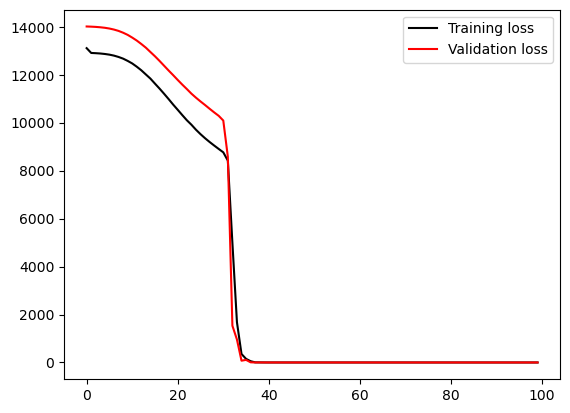

In [10]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

Plot the training dataset against the predictions:

<Axes: xlabel='x', ylabel='y'>

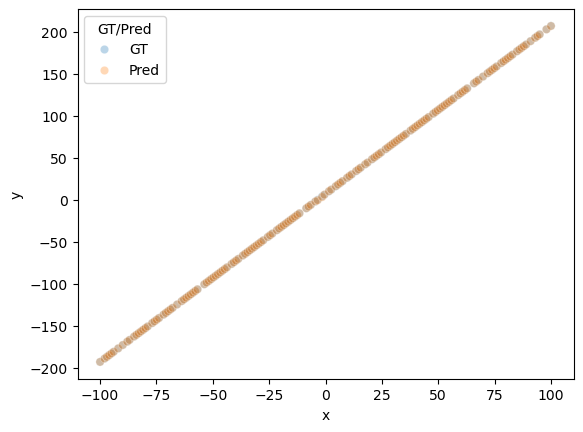

In [11]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"]) # Input
y_plot = np.array(training_df["y_range"]) # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_train = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha = 0.3)

Plot the test dataset against the predictions:

<Axes: xlabel='x', ylabel='y'>

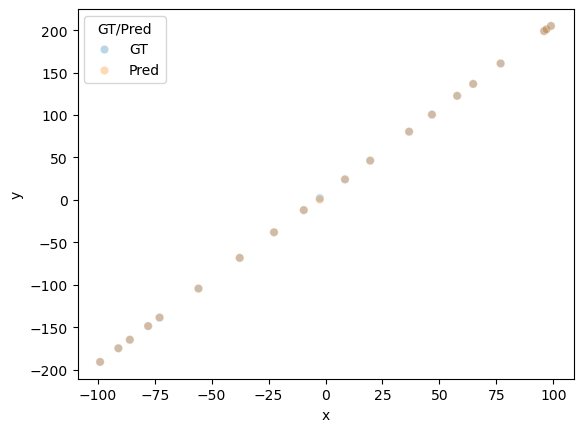

In [12]:
# Define the dataframe 
x_plot = np.array(test_df["x_range"]) # Input
y_plot = np.array(test_df["y_range"]) # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_test = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_test, x="x", y="y", hue="GT/Pred", alpha = 0.3)

## S2-2: Regression on noisy data:
we want to apply the same method on a noisy dataset.

In [13]:
chosen_df = "df_nonlinear_heteroscedastic_aleatoric.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

print(len(full_df))

full_df.head(8)

2000


,x_range,y_range,split_label
0,-100.00000,-1.951295,0
1,-99.89995,-2.157962,0
2,-99.79990,-2.372893,2
3,-99.69985,-2.008686,2
4,-99.59980,-1.708835,0
5,-99.49975,-2.099694,1
6,-99.39970,-1.998389,0
7,-99.29965,-2.213909,0


In [14]:
# Initilize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

In [15]:
# Size of each batch
batch_size = 10  

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [16]:
# Define the model:
model = nn.Sequential(
    nn.Linear(1, 8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

In [17]:
# Loss function (Mean Squared Error):
loss_fn = nn.MSELoss()  

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Number of training epochs:
n_epochs = 100

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  

        # Compute loss (supervised case)
        loss = loss_fn(y_model, y_output)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

        
            # Forward pass (model calls)
            y_model = model(x_input)

            # Compute loss (supervised case)
            loss = loss_fn(y_model, y_output)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            

    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/100], Loss: 0.5609, Val. Loss: 0.4188
Epoch [2/100], Loss: 0.3779, Val. Loss: 0.2575
Epoch [3/100], Loss: 0.2205, Val. Loss: 0.1415
Epoch [4/100], Loss: 0.1443, Val. Loss: 0.1181
Epoch [5/100], Loss: 0.1030, Val. Loss: 0.0868
Epoch [6/100], Loss: 0.0955, Val. Loss: 0.0891
Epoch [7/100], Loss: 0.0906, Val. Loss: 0.0796
Epoch [8/100], Loss: 0.0900, Val. Loss: 0.0836
Epoch [9/100], Loss: 0.0948, Val. Loss: 0.0701
Epoch [10/100], Loss: 0.0798, Val. Loss: 0.0832
Epoch [11/100], Loss: 0.0798, Val. Loss: 0.0735
Epoch [12/100], Loss: 0.0718, Val. Loss: 0.0619
Epoch [13/100], Loss: 0.0650, Val. Loss: 0.0563
Epoch [14/100], Loss: 0.0666, Val. Loss: 0.0543
Epoch [15/100], Loss: 0.0665, Val. Loss: 0.0914
Epoch [16/100], Loss: 0.0648, Val. Loss: 0.1027
Epoch [17/100], Loss: 0.0572, Val. Loss: 0.0468
Epoch [18/100], Loss: 0.0640, Val. Loss: 0.0661
Epoch [19/100], Loss: 0.0675, Val. Loss: 0.0879
Epoch [20/100], Loss: 0.0655, Val. Loss: 0.0463
Epoch [21/100], Loss: 0.0603, Val. Loss: 0.0804
E

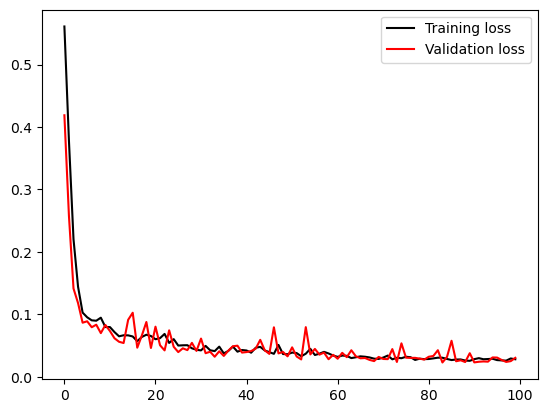

In [19]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

<Axes: xlabel='x', ylabel='y'>

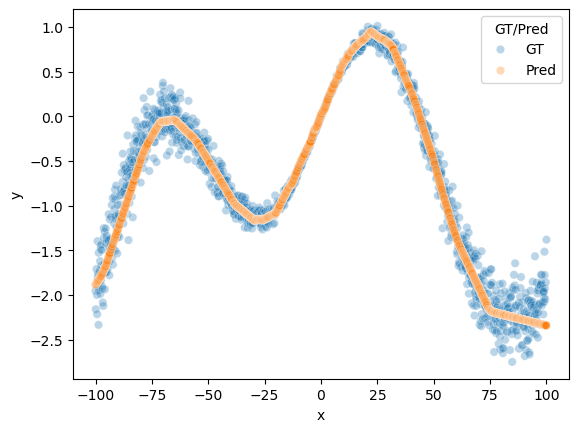

In [20]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"]) # Input
y_plot = np.array(training_df["y_range"]) # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_train = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha = 0.3)

<Axes: xlabel='x', ylabel='y'>

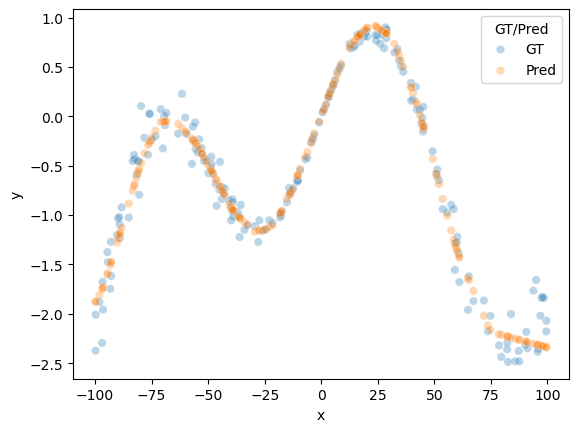

In [21]:
# Define the dataframe 
x_plot = np.array(test_df["x_range"]) # Input
y_plot = np.array(test_df["y_range"]) # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_test = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_test, x="x", y="y", hue="GT/Pred", alpha = 0.3)